In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Reshape, LSTM
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

In [2]:
data_directory = './data/Train-Test Set'

transform = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor(),
])

custom_dataset = ImageFolder(root=data_directory, transform=transform)

In [3]:
torch.manual_seed(42)

In [4]:
batch_size = 32
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
model2 = Sequential()

model2.add(Conv2D(64, (10, 10), activation='relu', input_shape=(640, 480, 3)))
model2.add(MaxPooling2D((10, 10)))
model2.add(Dropout(.2))
model2.add(Conv2D(128, (10, 10), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((5, 5)))
model2.add(Dropout(.2))
model2.add(Conv2D(256, (5, 5), activation='relu'))
model2.add(Conv2D(512, (2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(.1))
model2.add(Reshape((1024, 1)))
model2.add(LSTM(1024))
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(.1))
model2.add(Dense(1, activation='sigmoid'))

In [6]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 631, 471, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 47, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 47, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 38, 128)       819328    
                                                                 
 batch_normalization (Batch  (None, 54, 38, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 7, 128)        0

In [8]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
)
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    './data/Train-Test Set/Training',
    target_size=(640, 480),
    batch_size=8,
    class_mode='sparse'
)

validation_generator = test_datagen.flow_from_directory(
    './data/Train-Test Set/Validation',
    target_size=(640, 480),
    batch_size=8,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    './data/Train-Test Set/Testing',
    target_size=(640, 480),
    batch_size=8,
    class_mode='sparse'
)

Found 115 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [9]:
model2.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

C:\Users\user\AppData\Local\Temp\ipykernel_14956\1707472198.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(


Epoch 1/10
15/15 [==============================] - 289s 19s/step - loss: 1.0497 - accuracy: 0.5217 - val_loss: 0.7344 - val_accuracy: 0.4156
Epoch 2/10
15/15 [==============================] - 279s 19s/step - loss: 0.6930 - accuracy: 0.5826 - val_loss: 0.7480 - val_accuracy: 0.4156
Epoch 3/10
15/15 [==============================] - 282s 19s/step - loss: 0.6852 - accuracy: 0.5565 - val_loss: 0.7040 - val_accuracy: 0.4156
Epoch 4/10
15/15 [==============================] - 292s 19s/step - loss: 0.6827 - accuracy: 0.5826 - val_loss: 0.6975 - val_accuracy: 0.4416
Epoch 5/10
15/15 [==============================] - 289s 19s/step - loss: 0.6831 - accuracy: 0.5826 - val_loss: 0.6873 - val_accuracy: 0.5974
Epoch 6/10
15/15 [==============================] - 296s 20s/step - loss: 0.6786 - accuracy: 0.5826 - val_loss: 0.6857 - val_accuracy: 0.6364
Epoch 7/10
15/15 [==============================] - 299s 20s/step - loss: 0.6714 - accuracy: 0.5913 - val_loss: 0.8625 - val_accuracy: 0.4156
Epoch 

In [10]:
model2.save('cnn_only_4935.h5')

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\user\AppData\Local\Temp\ipykernel_14956\2867862681.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model2.predict_generator(test_generator)


Confusion matrix, without normalization
[[20  0]
 [25  3]]


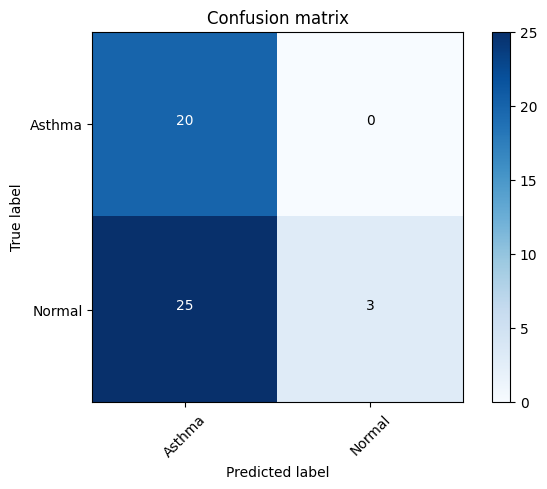

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

predictions = model2.predict_generator(test_generator)
y_pred = np.round(predictions).astype(int).flatten()  # Convert probabilities to class labels
# print(y_true, y_pred)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=validation_generator.class_indices.keys())

plt.show()